### Load Libraries

In [1]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from PyEMD import EMD, CEEMDAN
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import dtw
from collections import Counter
from tqdm import tqdm
import pandas as pd
import yfinance as yf
import numpy as np
import math
import os

seed=42

In [291]:
# define path for raw data
basepath = '../../datasets/rawdata/'

### Define Utilities

In [302]:
def load_data(basepath):
    # list all the raw data files in the base path
    stocks_files = os.listdir(basepath)

    # create column names based on the ticker name
    colnames = [stock.split('.')[0] for stock in stocks_files]
    
    frames = []
    # read the raw data for all the tickers and combine to create a dataframe
    for file in stocks_files:
        filepath = basepath + file
        
        # choose the Date and Adj Close column data from the raw data
        df = pd.read_csv(filepath, usecols=[0, 5])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        frames.append(df)
    df = pd.concat(frames, axis=1)
    df.columns = colnames
    df = df.reset_index()
    return(df)

def preprocess(df, start_date):
    # choose the data as per start date provided and handle missing values in the data
    cond = np.where(df['Date'] > start_date)
    
    # choose 120-150 days of data
    data = df.iloc[cond].copy()
    
    # drop ticker column, which has only null values 
    data = data.dropna(axis=1, how='all')
    
    # drop row, which has only null values for all the tickers
    data = data.dropna(axis=0, how='all')
    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill')
    data = data.set_index('Date')
    return(data)    

def scaling(df, scaling):
    # scale the data with minmax/standard scaling based on option
    if scaling == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    data_df = df.copy()
    scaled_df = scaler.fit_transform(data_df)
    scaled_df = pd.DataFrame(scaled_df)
    scaled_df.columns = stocks_df.columns
    return(scaled_df)

def log_returns(df):
    # preprocess the stocks data as log returns 
    data_df = df.copy()
    log_df = np.log(data_df)
    log_scaled = np.diff(log_df, axis=0)
    log_scaled = pd.DataFrame(log_scaled, columns=data_df.columns)
    return(log_scaled)

def kelbow_visualizer(X):
    kmeans = TimeSeriesKMeans(n_jobs=-1, metric='dtw', random_state=seed)    
    visualizer = KElbowVisualizer(kmeans, k=(5, 25), timing=False)
    visualizer.fit(X)
    visualizer.show()    
    
def extract_imfsby_ceemdan(signal):
    ceemdan = CEEMDAN()
    imfs = ceemdan(signal)    
    return(imfs)            

def ceemdan_feature(df):
    data_df = df.copy()
    ticker_list = data_df.columns

    preprocessed_dataset = []
    for ticker in tqdm(ticker_list):
        signal = data_df[ticker].values
        imfs = extract_imfsby_ceemdan(signal)
        
        # choosing top three imfs as feature
        preprocessed_dataset.append(np.concatenate(imfs[:3]))    
    return(preprocessed_dataset)


def plot_clusters(df, cluster_labels):
    plot_count = math.ceil(math.sqrt(len(set(cluster_labels))))
    fig, axis = plt.subplots(plot_count, plot_count, figsize=(25, 25))
    row = 0
    col = 0

    for cluster_label in set(cluster_labels):
        cluster_cond = np.where(cluster_labels == cluster_label)[0].tolist()
        cluster_df = df.iloc[:, cluster_cond].copy()
        ticker_list = cluster_df.columns.tolist()
        cur_cluster = []

        for ticker in ticker_list:
            axis[row, col].plot(cluster_df[ticker], c='gray', alpha=0.4)
            cur_cluster.append(cluster_df[ticker])

        if len(ticker_list) > 0:
            axis[row, col].plot(np.average(np.vstack(cur_cluster), axis=0), c='green')  
            axis[row, col].plot(dtw_barycenter_averaging(np.vstack(cur_cluster)), c='red')  
            axis[row, col].set_title('Cluster ' + str(cluster_label))
            axis[row,col].title.set_size(20)
        col += 1

        if col % plot_count == 0:
            row += 1
            col = 0

### Load Data

In [250]:
# load the raw data for all the tickers     
df = load_data(basepath)
df.sample(5)

Date      360ONE       3MINDIA  AARTIDRUGS    AARTIIND  \
3943 2023-03-10  438.007812  23582.800781  340.149994  533.250000   
1815 2014-12-30         NaN   6264.436523   94.152740   60.096951   
3195 2020-04-24  192.338150  18461.718750  179.122238  459.033264   
3525 2021-08-02  328.878540  23810.087891  666.470154  941.326233   
938  2011-08-16         NaN   4485.764160   12.293343    8.657933   

            AAVAS    ABBOTINDIA   ABCAPITAL       ABFRL    ABSLAMC  \
3943  1788.050049  20554.650391  153.649994  235.000000  366.82309   
1815          NaN   3549.969971         NaN  122.099998        NaN   
3195  1175.750000  15817.984375   47.049999  118.087730        NaN   
3525  2469.699951  19501.314453  118.949997  224.500000        NaN   
938           NaN   1298.457397         NaN         NaN        NaN   

             ACI         ACN     ADANIENT  ADANIGREEN  ADANIPORTS  ADANIPOWER  \
3943  635.900024  251.960571  1896.199951  682.700012  697.799988  204.899994   
1815         NaN   78.291595    69.298592         NaN  303.183472   44.349998   
3195         NaN  168.344040   134.503494  195.949997  266.917969   30.650000   
3525         NaN  308.425201  1437.588867  876.150024  687.239075   92.849998   
938          NaN   43.775043    73.043037         NaN  131.478165   89.050003   

      ADANITRANS   AEGISCHEM      AETHER       AFFLE       AIAENG  \
3943  904.450012  381.299988  870.450012  991.000000  2800.350098   
1815         NaN   40.899445         NaN         NaN  1007.065552   
3195  196.050003  172.035675         NaN  290.130005  1475.465820   
3525  908.799988  296.124451         NaN  851.880005  1948.920410   
938          NaN   17.132887         NaN         NaN   331.066315   

       AJANTPHARM    AKZOINDIA        ALKEM   ALKYLAMINE   ALOKINDS  \
3943  1219.900024  2280.850098  3145.850098  2496.000000  13.050000   
1815   592.435730  1153.589966          NaN   131.797882  10.050000   
3195   947.291565  1836.765503  2657.404053   654.613831   7.350000   
3525  1487.483643  2139.600830  3417.286865  4398.145508  24.500000   
938     24.950668   683.968079          NaN    14.135459  17.251738   

      AMARAJABAT        AMBER   AMBUJACEM     ANGELONE      ANURAS  \
3943  573.299988  1992.750000  378.350006  1130.616455  746.189636   
1815  757.211487          NaN  196.563919          NaN         NaN   
3195  518.396362  1085.400024  151.994415          NaN         NaN   
3525  711.865173  3017.649902  409.391022  1249.222900  719.585083   
938   106.336609          NaN  107.011177          NaN         NaN   

         APARINDS    APLAPOLLO      APLLTD   APOLLOHOSP  APOLLOTYRE  \
3943  2304.600098  1199.150024  498.950012  4317.250000  312.000000   
1815   354.213257    32.009678  409.851471  1104.175537  191.763412   
3195   288.455139   129.248474  737.829468  1350.932373   87.092682   
3525   642.180420   883.706116  769.134338  4029.198975  224.607788   
938    142.134857          NaN         NaN   504.359802   47.510204   

           APTUS  ASAHIINDIA    ASHOKLEY   ASIANPAINT     ASTERDM  \
3943  249.008423  481.700012  145.399994  2811.477295  231.199997   
1815         NaN  111.693832   43.142242   705.672302         NaN   
3195         NaN  162.599991   44.198719  1787.149780  104.250000   
3525         NaN  372.942108  132.546997  2929.755615  161.850006   
938          NaN   67.344009   19.746180   296.512238         NaN   

           ASTRAL     ASTRAZEN        ATGL         ATUL      AUBANK  \
3943  1428.712524  3314.550049  949.599976  6993.850098  624.500000   
1815   175.524857   822.607605         NaN  1343.958252         NaN   
3195   502.898499  2755.159668   97.222450  4571.969238  258.802399   
3525  1630.625000  3351.842529  888.266846  9062.157227  611.324219   
938     16.817839  1354.309692         NaN   183.492462         NaN   

      AUROPHARMA  AVANTIFEED    AWL    AXISBANK   BAJAJ-AUTO    BAJAJELEC  \
3943  453.500000  364.549988  453.5  851.900024  3821.899902  1084.650024   
18

#### Prepocess the data

In [257]:
# choose approx five months of data
start_date = '2023-01-01'

# select last five months data and handle any missing values
stocks_df  = preprocess(df, start_date)

### 1. Using MinMaxScaler for scaling

In [11]:
# scale the data using minmax scaler
%time
scaled_df = scaling(stocks_df, 'minmax')
X = scaled_df.T
X.head(3)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 4.53 µs


0         1         2         3         4         5    \
360ONE      0.494520  0.469670  0.481186  0.514521  0.470125  0.487550   
3MINDIA     0.000000  0.029079  0.164475  0.266415  0.238152  0.379362   
AARTIDRUGS  0.903518  0.878881  0.850249  0.869559  0.853245  0.853911   

                 6         7         8         9    ...       96        97   \
360ONE      0.509824  0.418910  0.543614  0.494217  ...  0.104833  0.059735   
3MINDIA     0.319605  0.200846  0.250533  0.269012  ...  0.545648  0.560927   
AARTIDRUGS  0.861569  0.874220  0.849583  0.861236  ...  0.994326  1.000000   

                 98        99        100       101       102       103  \
360ONE      0.073326  0.084446  0.223447  0.180820  0.227153  0.232713   
3MINDIA     0.726565  0.845037  0.772055  0.838666  0.741708  0.818556   
AARTIDRUGS  0.950267  0.983979  0.903872  0.861482  0.858144  0.869159   

                 104       105  
360ONE      0.276576  0.270398  
3MINDIA     0.797630  1.000000  
AARTIDRUGS  0.846128  0.832110  

[3 rows x 106 columns]

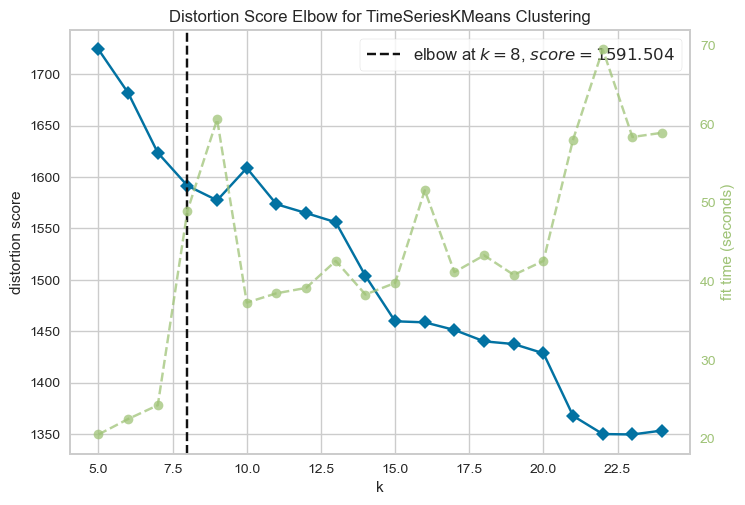

In [8]:
%time
kelbow_visualizer(X)

#### Fit the data to cluster number as per elbow method

In [9]:
kmeans = TimeSeriesKMeans(n_clusters=8, n_jobs=-1, metric='dtw', random_state=seed)
minmax_cluster_labels = kmeans.fit_predict(X)

#### Plot ticker's timseries in clusters

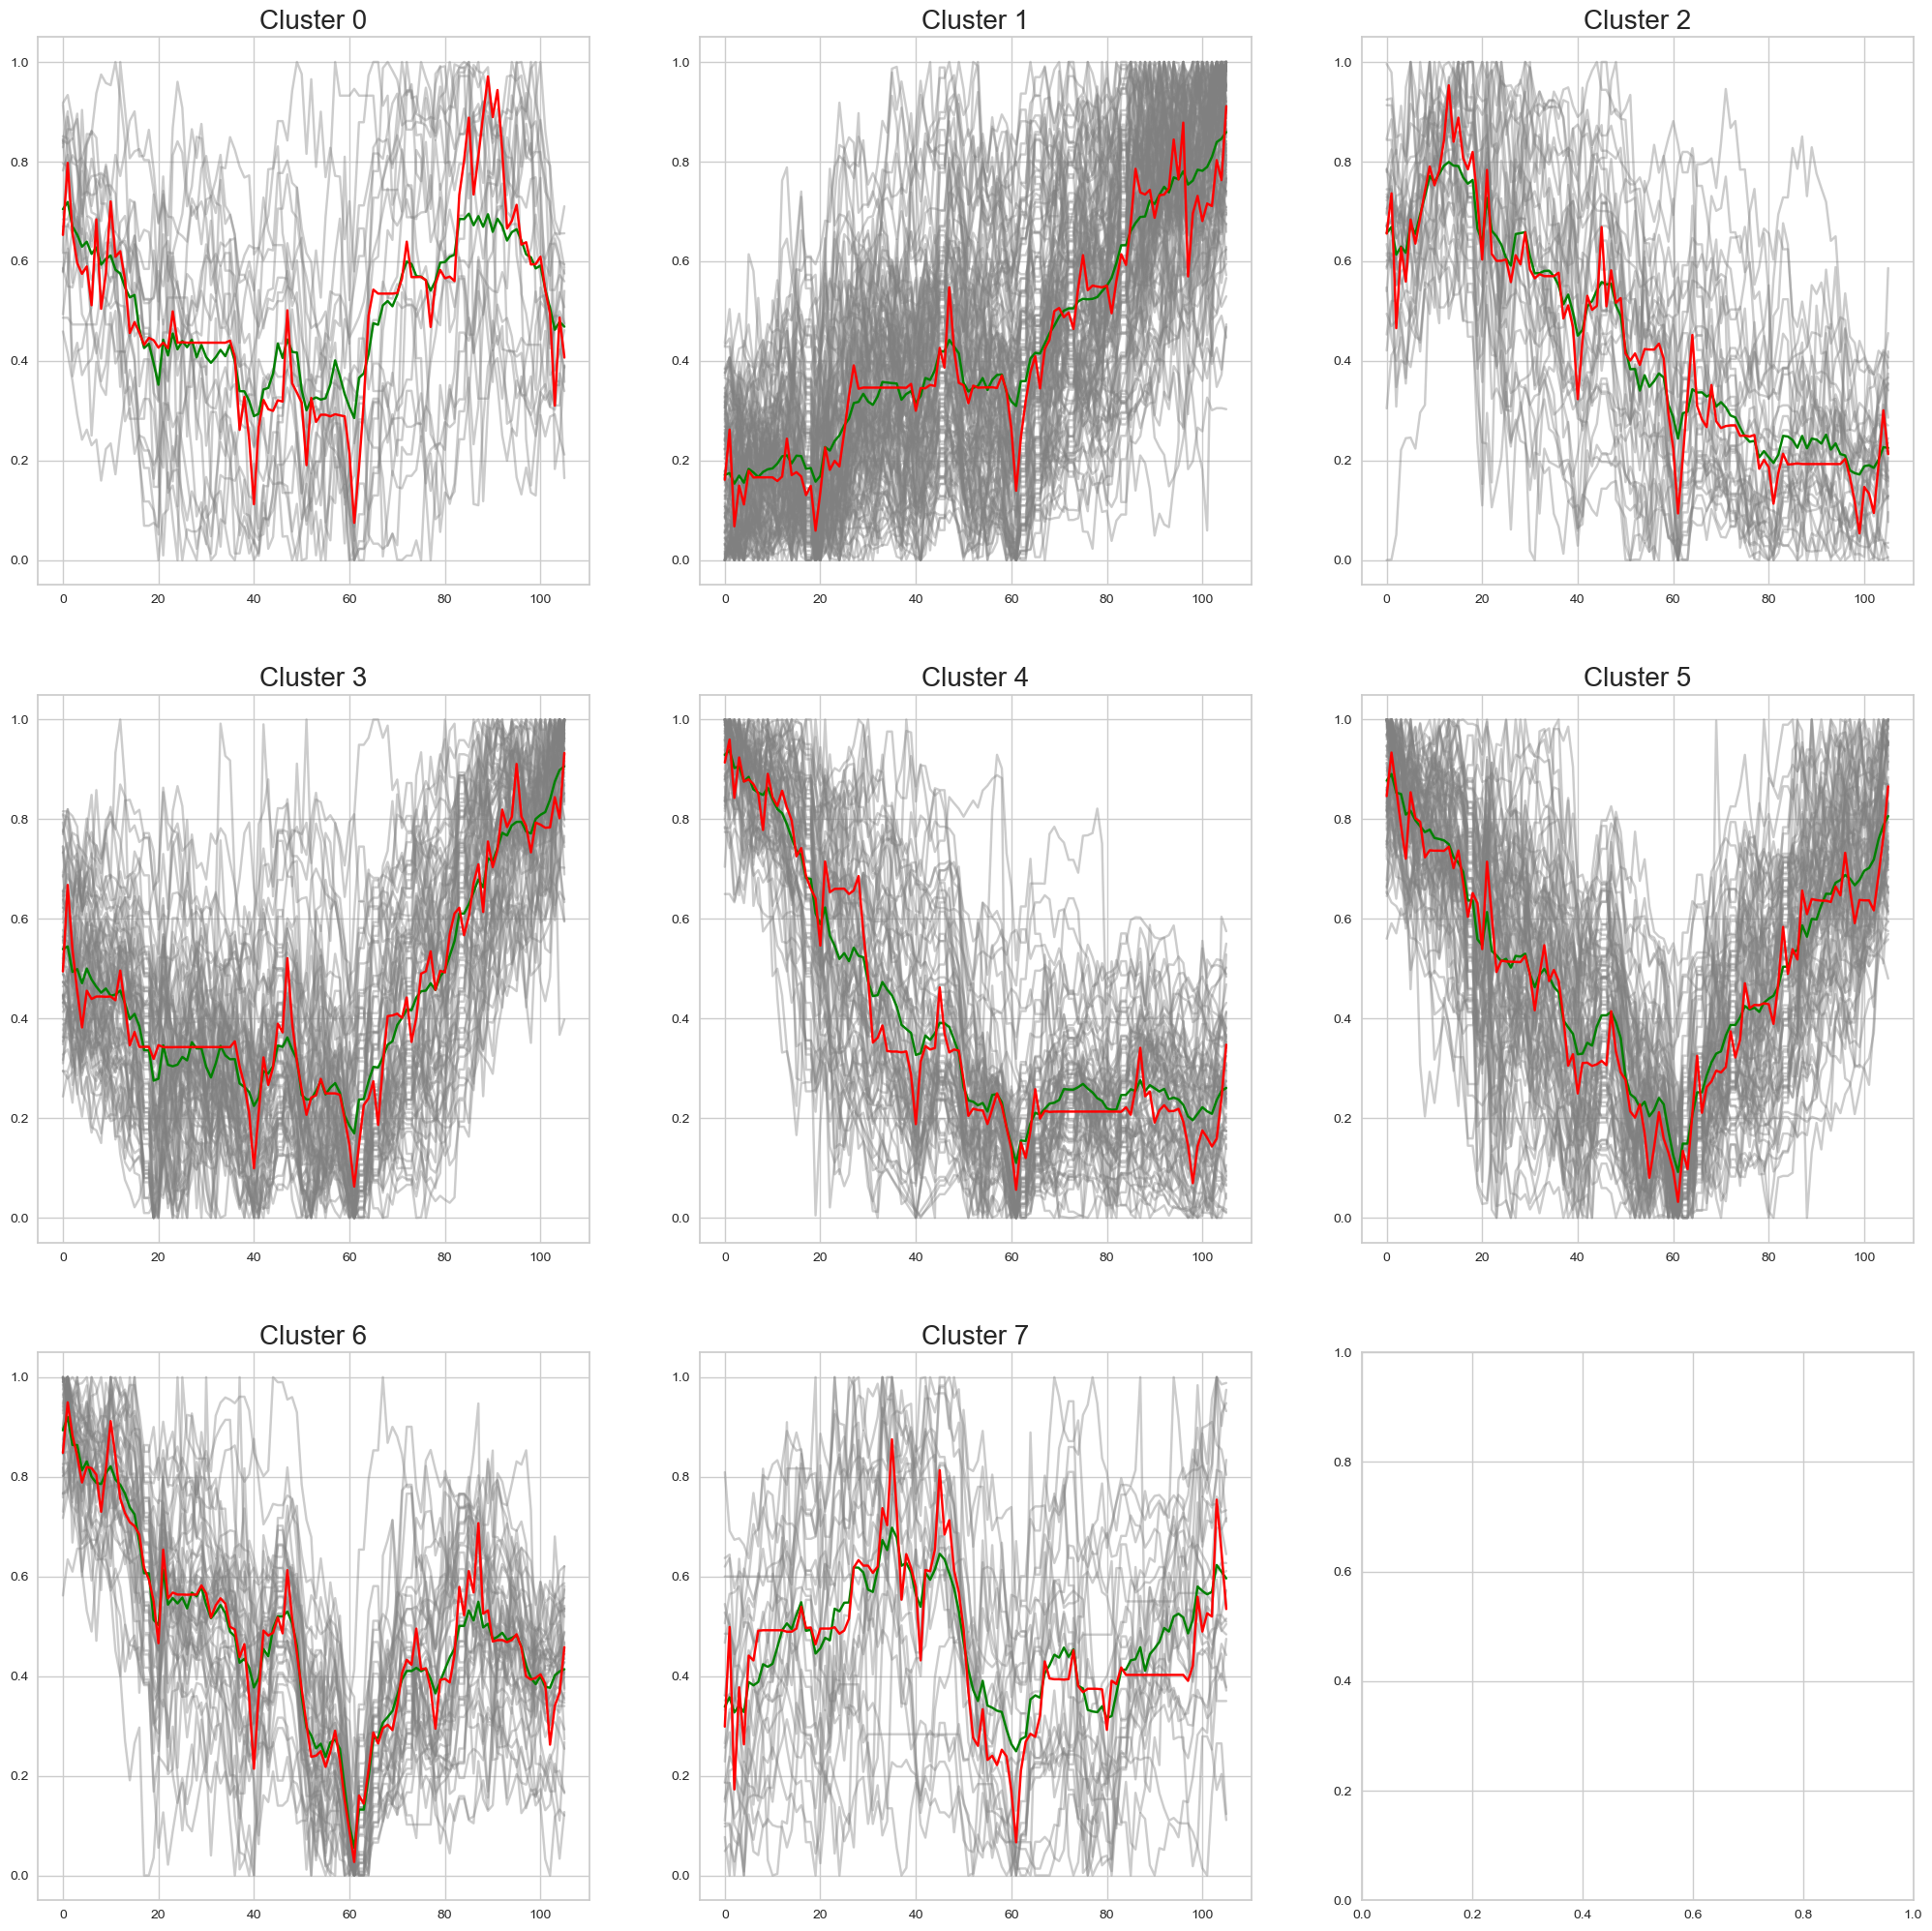

In [303]:
plot_clusters(scaled_df, minmax_cluster_labels)        

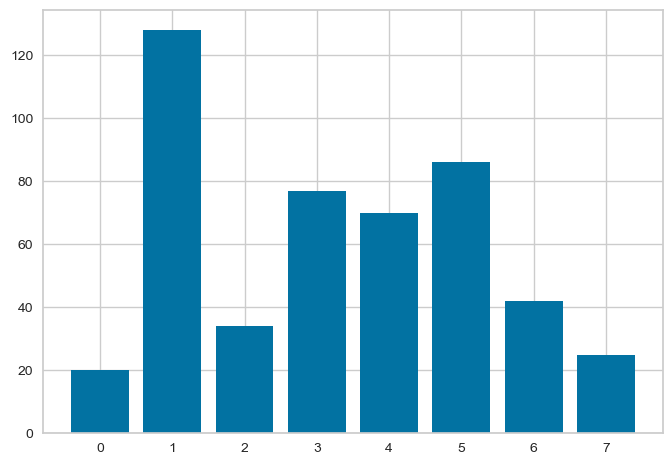

In [214]:
minmax_cluster_labels_dict = Counter(minmax_cluster_labels)
plt.bar(minmax_cluster_labels_dict.keys(), minmax_cluster_labels_dict.values())
plt.show()

### Using Standard Scaling for Scaling

In [54]:
# scale data using log returns
scaling_opt = 'standard'
standard_scaled_df = scaling(stocks_df, scaling_opt)
X = standard_scaled_df.T

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.87 µs


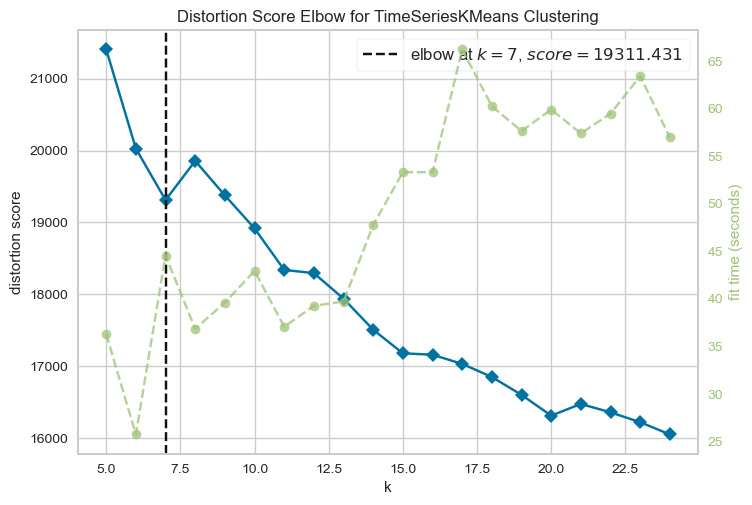

In [55]:
%time
kelbow_visualizer(X)

In [56]:
#### Fit the data to cluster number as per elbow method
kmeans = TimeSeriesKMeans(n_clusters=7, n_jobs=-1, metric='dtw', random_state=seed)
standard_cluster_labels = kmeans.fit_predict(X)

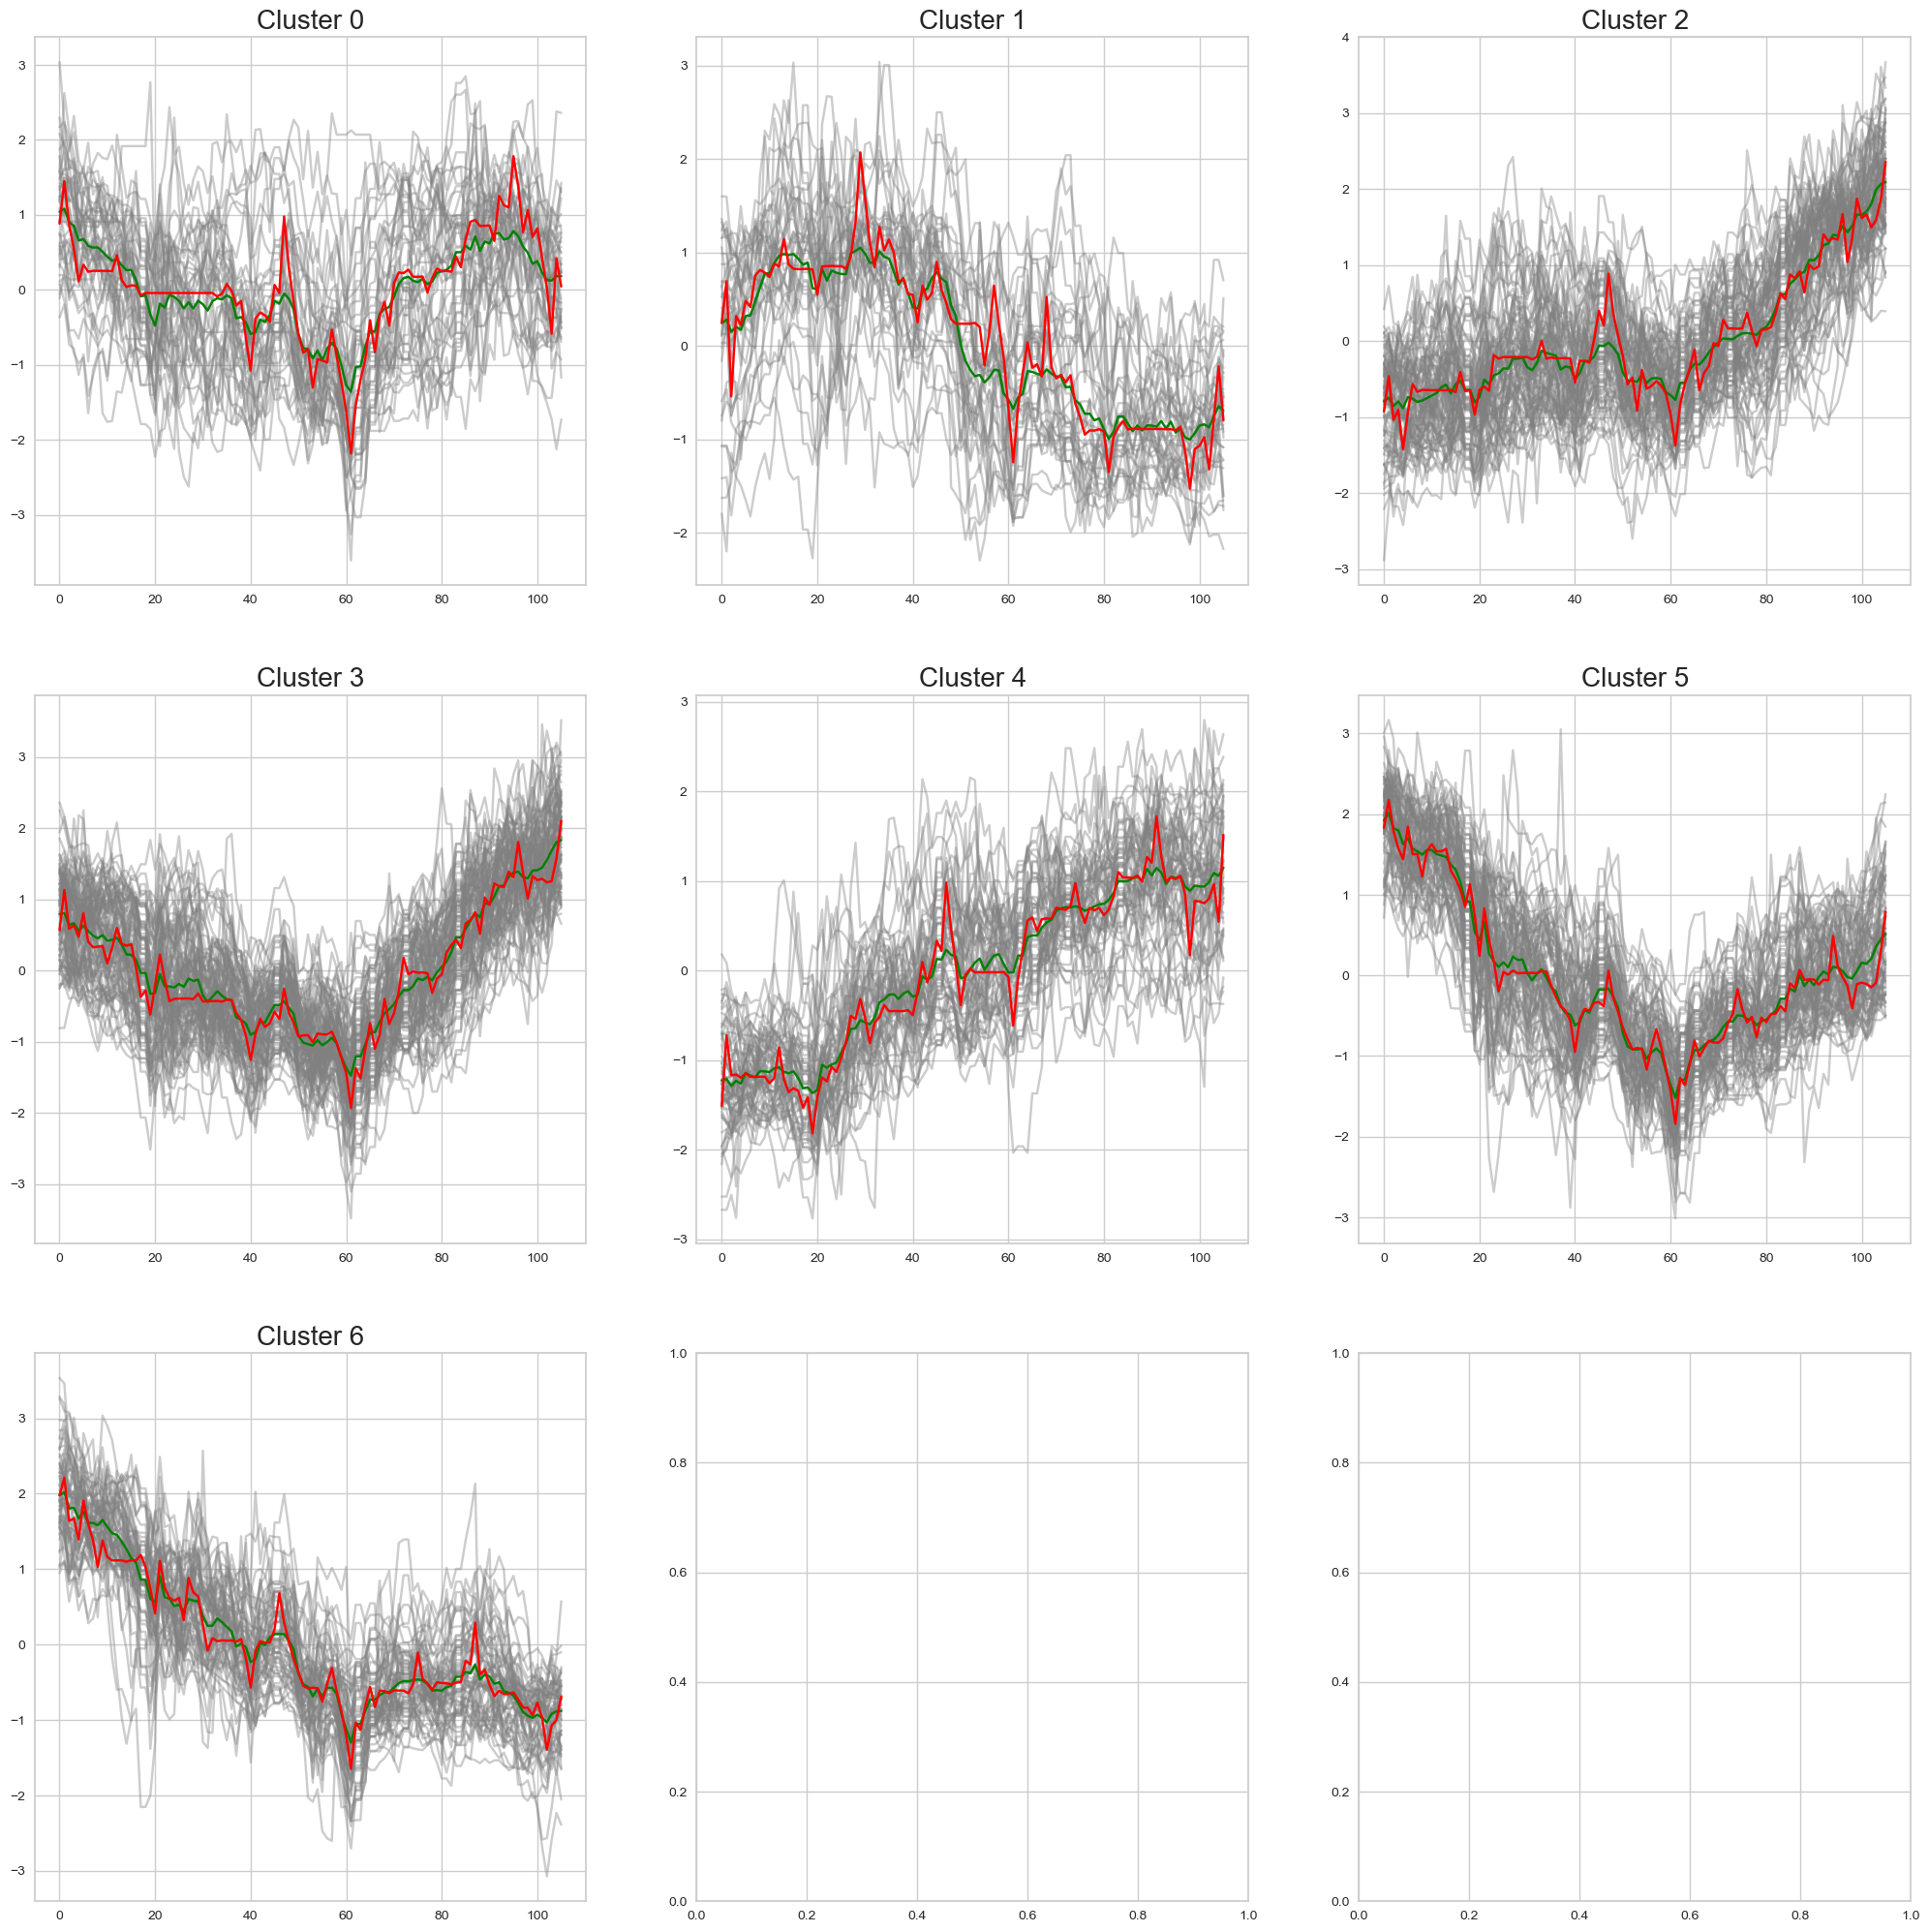

In [304]:
plot_clusters(standard_scaled_df, standard_cluster_labels)

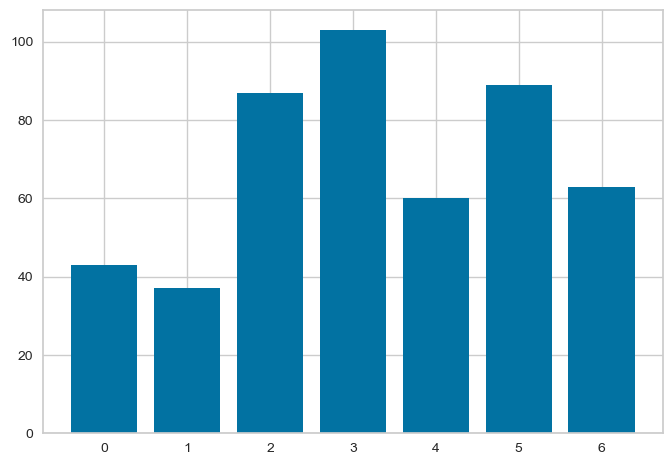

In [205]:
standard_cluster_labels_dict = Counter(standard_cluster_labels)
plt.bar(standard_cluster_labels_dict.keys(), standard_cluster_labels_dict.values())
plt.show()

### 3. Using log returns for Scaling

In [16]:
# scale data using log returns
log_scaled_df = log_returns(stocks_df)
X = log_scaled_df.T

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 7.39 µs


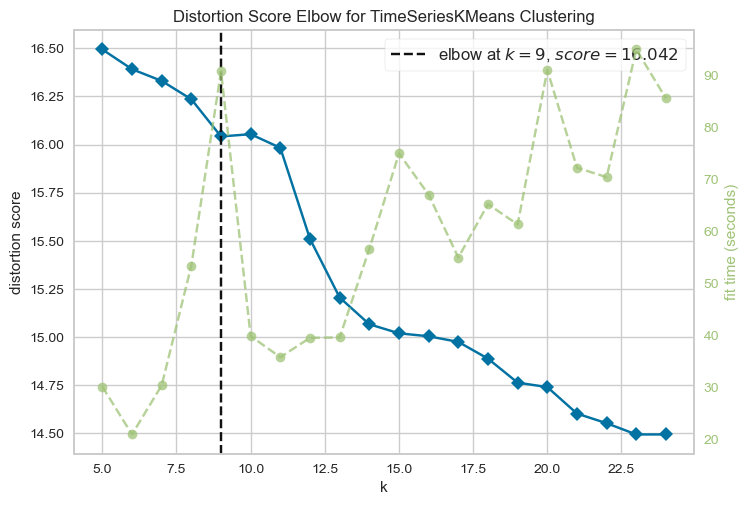

In [17]:
%time
kelbow_visualizer(X)

In [18]:
#### Fit the data to cluster number as per elbow method
kmeans = TimeSeriesKMeans(n_clusters=9, n_jobs=-1, metric='dtw', random_state=seed)
log_cluster_labels = kmeans.fit_predict(X)

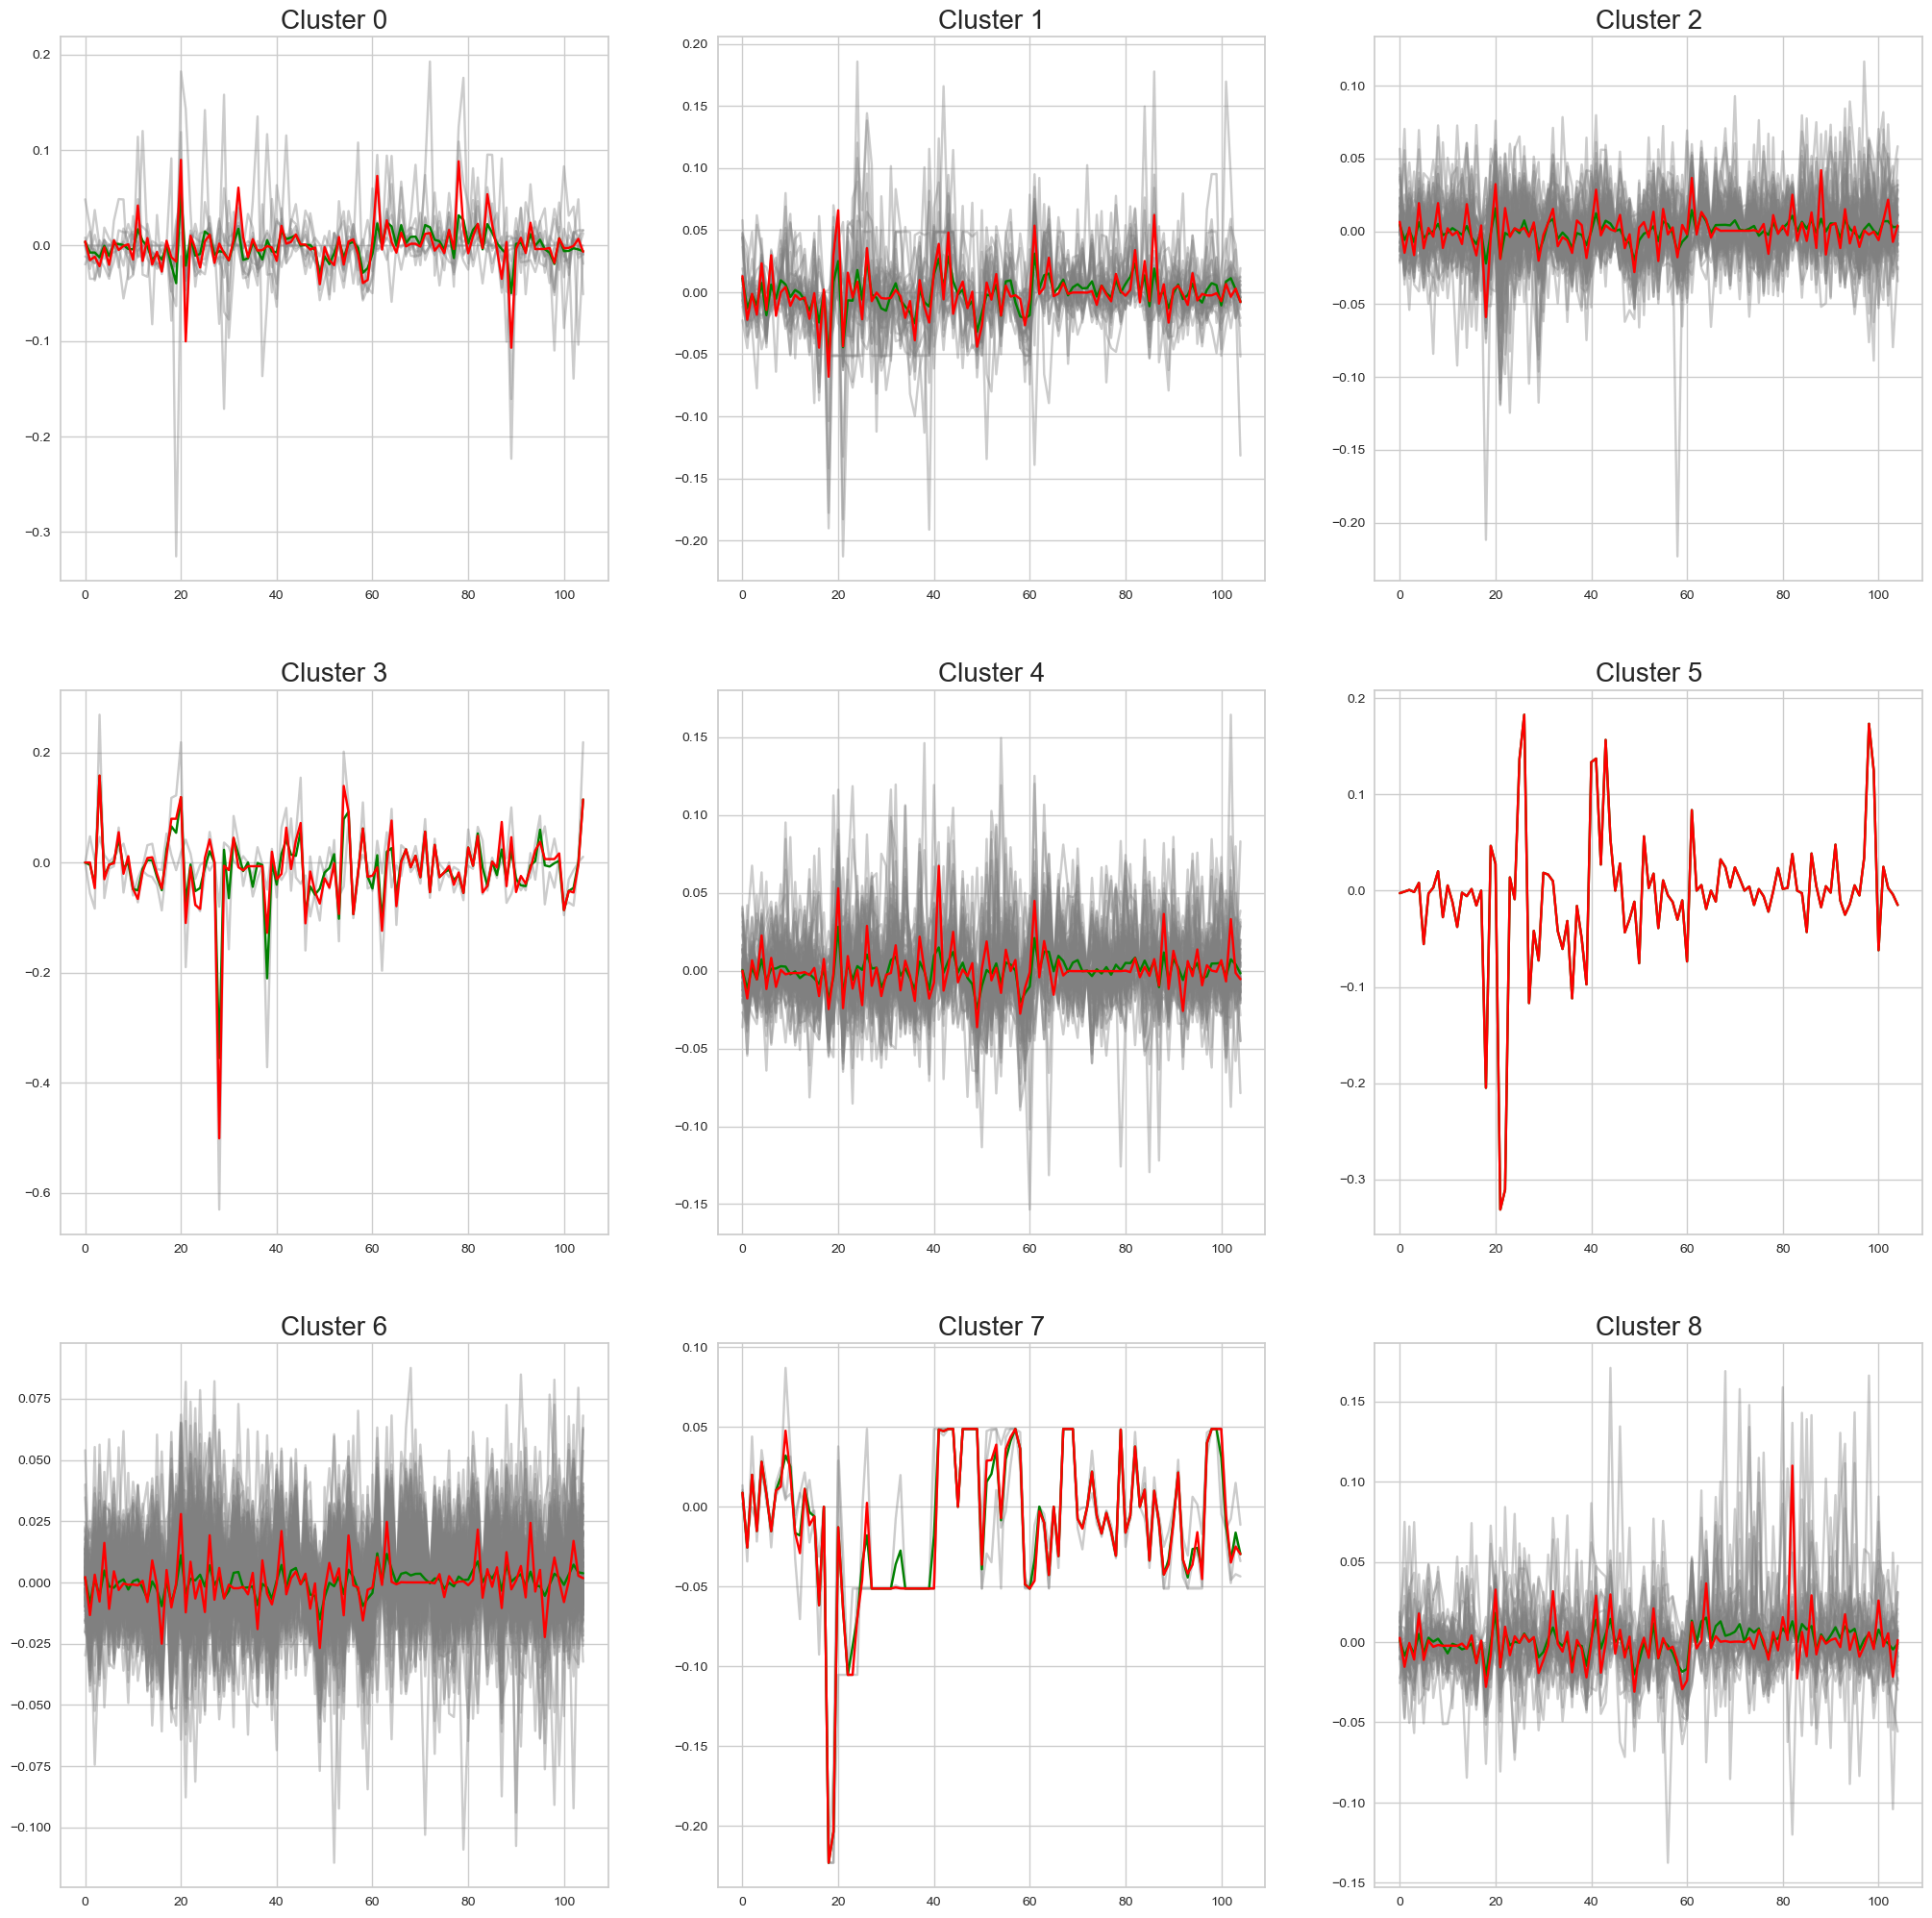

In [305]:
plot_clusters(log_scaled_df, log_cluster_labels)        

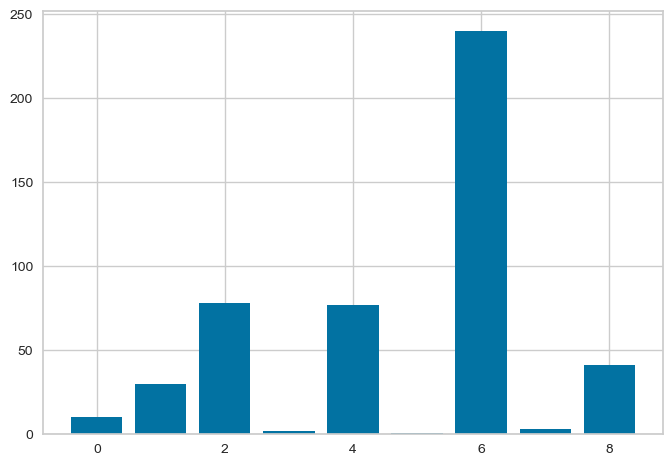

In [307]:
log_cluster_labels_dict = Counter(log_cluster_labels)
plt.bar(log_cluster_labels_dict.keys(), log_cluster_labels_dict.values())
plt.show()

### 4. Using CEEMDAN preprocessing method

In [23]:
# extract IMF features using CEEMDAN
preprocessed_dataset = ceemdan_feature(stocks_df)
X = np.array(preprocessed_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████| 482/482 [14:38<00:00,  1.82s/it]


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


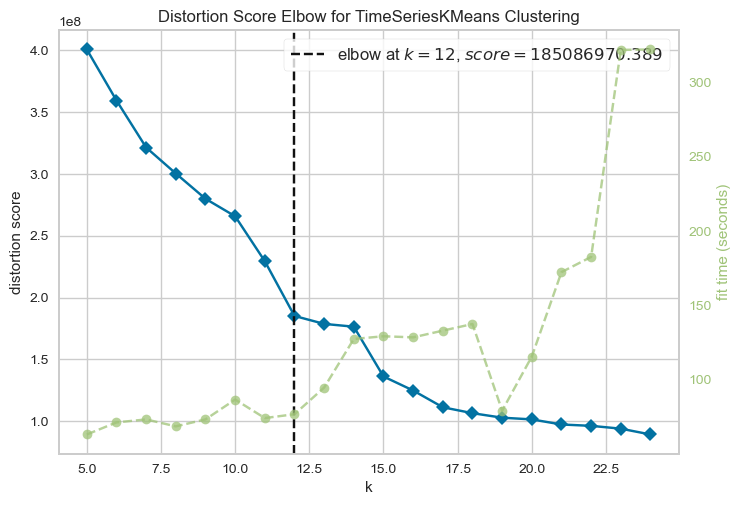

In [24]:
# use k-means to do clusterinf and visualizing the clustering 
%time
kelbow_visualizer(X)

In [25]:
#### Fit the data to cluster number as per elbow method
kmeans = TimeSeriesKMeans(n_clusters=8, n_jobs=-1, metric='dtw', random_state=seed)
ceemdan_cluster_labels = kmeans.fit_predict(X)

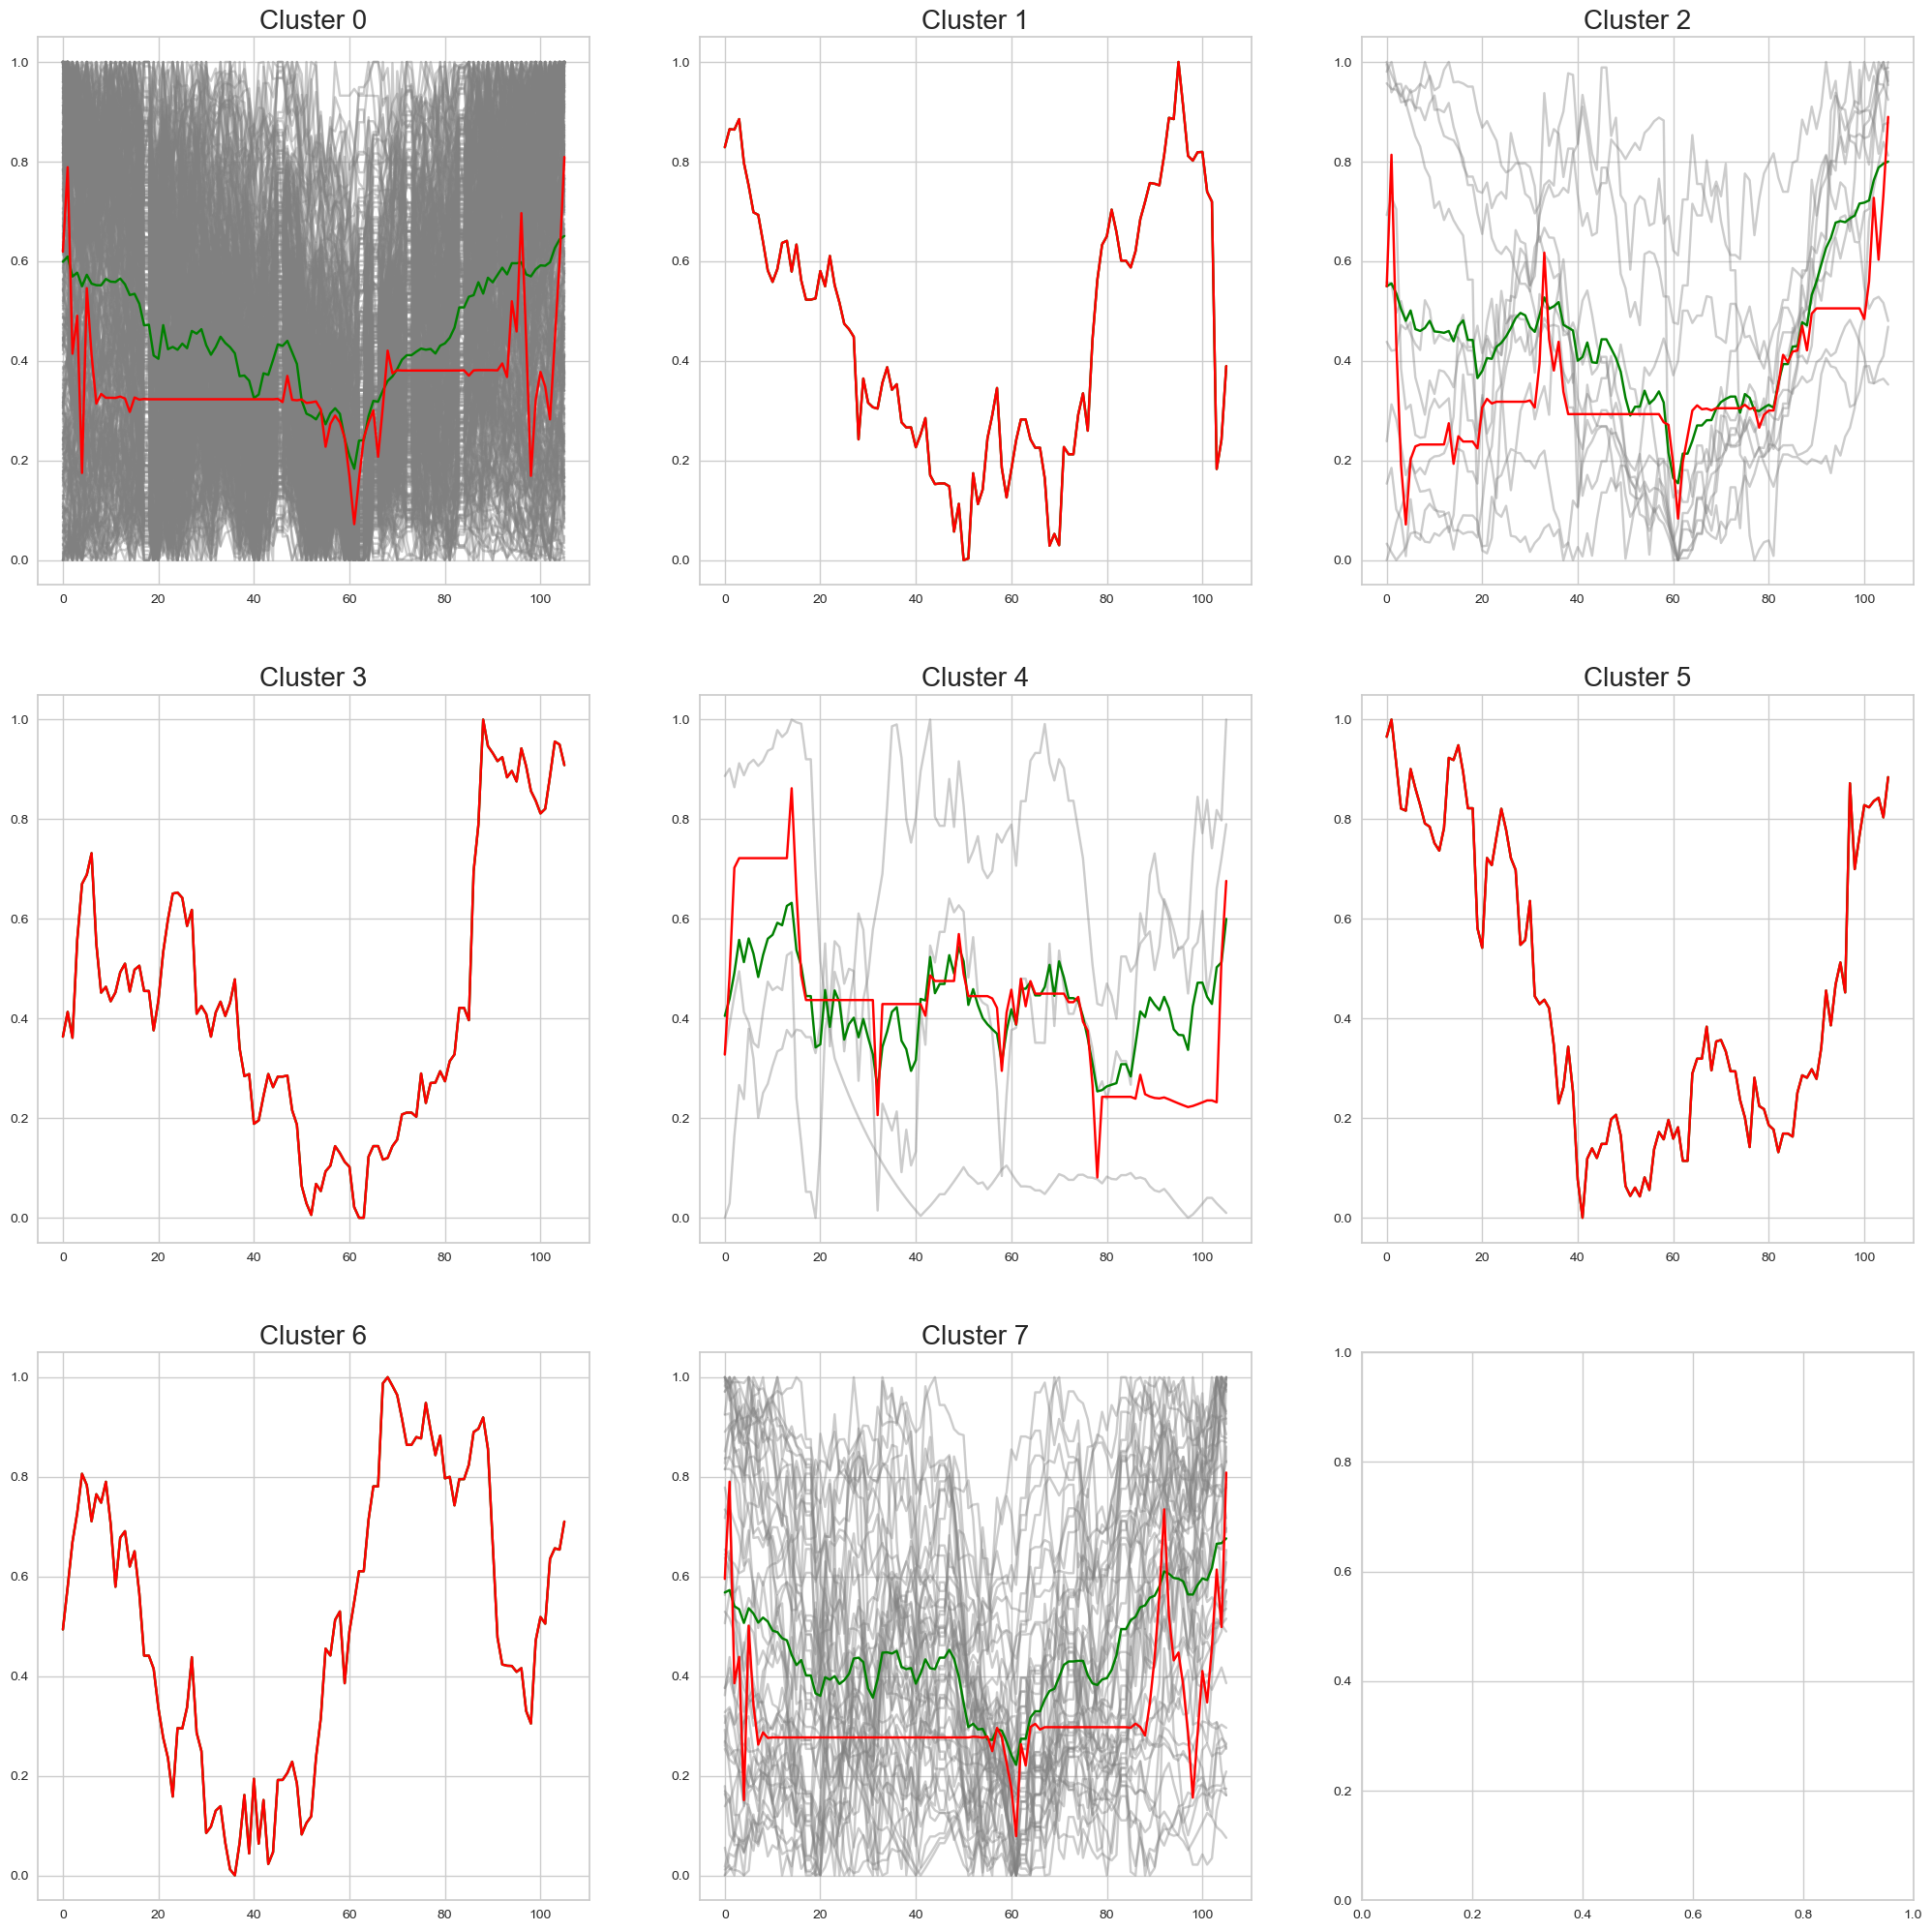

In [306]:
# plot the clusters
plot_clusters(scaled_df, ceemdan_cluster_labels)        

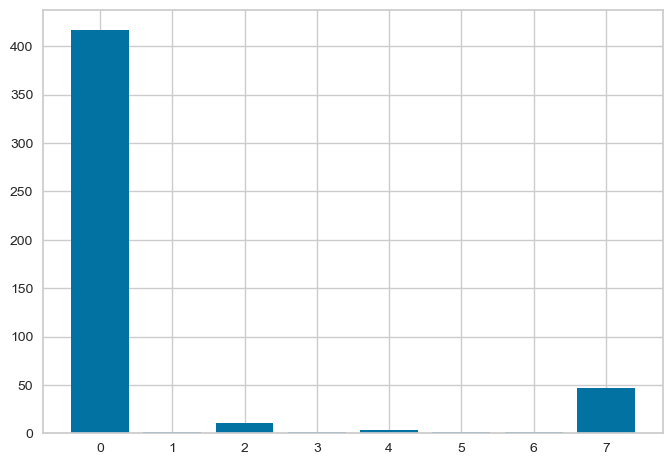

In [195]:
labels_dict = Counter(ceemdan_cluster_labels)
plt.bar(labels_dict.keys(), labels_dict.values())
plt.show()

### Observation: Clustering with StandardScaler is better than others

#### Compute dissimilarity matrix between stocs across clusters

In [275]:
def extract_max_dis_pairs(ds_df, cluster_labels):
    df = pd.DataFrame(ds_df.idxmax()).reset_index()
    df.columns = ['row', 'col']

    # get max dissimilarity values across different stocks pairs
    df['max_dis_val'] = ds_df.max()
    
    # get cluster labels
    df['cluster_src'] = cluster_labels
    df['cluster_target'] = df['col'].apply(lambda x: cluster_labels[x])
    df = df.sort_values(['max_dis_val'], ascending=[False]).reset_index(drop=True)
    return(df)

def get_max_dis_stocks(df, cluster_labels):
    data_df = df.copy()
    df = pd.DataFrame(columns=data_df.columns)

    for label in set(cluster_labels):
        # for every cluster label, get the stocks pair with max dissimilarity metric value
        cond = np.where(data_df['cluster_src'] == label)
        dis_df = data_df.iloc[cond].head(1).copy()
        df = pd.concat([df, dis_df], axis=0).sort_values('max_dis_val', ascending=False).reset_index(drop=True) 

    # combine the stocks in both source/target pair cluster
    stocks_list = list(set(pd.concat([df['row'], df['col']]).values.tolist()))
    return(stocks_list, df)

In [277]:
# compute the dissimilarity matrix using DTW(dynamic time warping) metric
ds_matrix = dtw.distance_matrix_fast(np.array(standard_scaled_df).T)
ds_df = pd.DataFrame(ds_matrix)
ds_df.head()

0          1          2          3          4         5          6    \
0   0.000000  11.505145   9.942732   7.345978   3.550697  7.596286  13.184772   
1  11.505145   0.000000   8.976077  15.651113  15.003609  6.964591   5.622584   
2   9.942732   8.976077   0.000000   9.692383  13.804357  4.949556   4.135249   
3   7.345978  15.651113   9.692383   0.000000   6.863144  7.536857  12.524393   
4   3.550697  15.003609  13.804357   6.863144   0.000000  8.886867  15.908483   

         7          8          9          10         11         12   \
0   5.653217   5.514618   4.990336   8.591282   7.377394   6.326645   
1  16.630223  15.247442  13.129250   4.071490  13.537235  14.482605   
2  12.021928   8.830128  14.220438   6.967155   5.432715   7.773869   
3   4.352854   4.948692  11.661244  12.422472   6.438753   5.706380   
4   5.084896   6.806939   4.976508  12.595861   9.820794   9.061858   

         13         14         15         16         17         18   \
0   8.077115   8.123283   6.207586   8.748813   9.908899   3.544465   
1  11.621055  11.477184  15.945663   8.132360   6.827450  13.627145   
2   4.277481   2.944051  10.110154   9.419026   8.954973  10.209823   
3   8.114852   7.797366   5.405997  12.843924  13.243314   4.236517   
4  11.540026  11.883590   7.757828   9.884876  11.329539   3.494460   

         19         20         21         22         23         24   \
0  11.215375  14.312639  13.917048  11.107934   5.429939   7.831485   
1   5.123363   5.157707   4.625928   6.463893  12.271230  13.088065   
2   9.741862   6.604013   7.472359   9.788523   5.118049   6.167436   
3  14.968847  13.842941  15.637191  14.420580   6.024944   5.101748   
4  13.241821  15.902691  17.105732  12.448775   8.350244   9.647891   

         25         26         27         28         29         30   \
0  11.650083  10.313591   7.586958   9.394145  16.383875  14.282923   
1   5.222615   5.906358  13.435761   9.034345   6.646360   6.538223   
2   6.614324   7.701447   5.738495   2.424578   7.477549  10.067714   
3  12.531787  13.622273   6.293470   7.645430  15.310917  16.128643   
4  13.525618  13.625317  10.643698  11.114137  17.795353  15.282037   

         31         32         33         34         35         36   \
0   7.366851   9.351465  11.116480  13.217941   6.713546   5.006262   
1  11.488209   9.729209   5.924354   5.188381  13.244703  13.782088   
2  13.034599   2.683059   6.035077   5.931461   6.299810   7.867799   
3  13.613130   8.109534  11.007524  14.667675   5.197942   3.647724   
4   7.520227  12.551012  13.877805  16.709983   9.114577   5.051922   

         37         38         39         40        41         42         43   \
0   7.687196  11.443018  14.099454  10.974810  3.957168   6.323454   7.201628   
1   8.295494   7.770372   5.773041   6.473040  9.396063  16.338271  15.865404   
2   3.790855   3.806053   5.322921   5.067725  5.554052  10.529992  10.717433   
3   8.071070  12.962868  13.670574  13.660048  6.062223   5.835883   3.886095   
4  10.550115  15.316732  16.344114  14.611893  5.165715   7.794887   7.342093   

         44         45        46         47         48         49         50   \
0  12.837422  16.670788  5.760497   6.839864   8.524820  15.603962   8.859099   
1   6.128428   6.170073  9.323862  13.266758  11.035778   5.874436   8.892099   
2   5.279918   8.324444  2.749817   5.614556   3.704568   9.511486   3.422791   
3  14.140763  15.572460  6.755987   4.703545   8.793300  16.744676   8.321860   
4  16.359005  17.434180  8.436355   8.620991  12.098996  17.808295  12.321877   

         51         52         53         54         55         56   \
0   9.532709  12.675648  11.006983   6.896289   9.174755   9.019052   
1  10.310211   4.783578   6.908543  12.950860   6.652922   7.908570   
2   4.815151   8.870615   4.438151   6.203832   4.804604   4.890714   
3   9.230225  15.177984  12.473310   4.293860  11.424423   8.592451   
4  12.497605  14.390312  14.693797   8.313784  12.756569  

In [218]:
max_dissim_df = extract_max_dis_pairs(ds_df, standard_cluster_labels)    
max_dissim_df.head(3)

row  col  max_dis_val  cluster_src  cluster_target
0  258  466    20.409269            4               6
1  466  258    20.409269            6               4
2  227  466    20.074778            4               6

In [230]:
# get stocks with maximum dissimilarity 
stocks_idx, df = get_max_dis_stocks(df, standard_cluster_labels)    
stocks_idx

[448, 97, 258, 477, 325, 273, 466, 123, 221, 478]

In [236]:
stocks_list = stocks_df.iloc[:, stocks_idx].columns.tolist()
print(stocks_list)

['TTML', 'CHOLAFIN', 'KSB3', 'ZENSARTECH', 'OFSS', 'LXCHEM', 'VMART', 'DLF', 'IPCALAB', 'ZFCVINDIA']


In [287]:
plot_df = stocks_df.iloc[:, stocks_idx].copy()
plot_df = plot_df.reset_index()
melt_df = plot_df.melt(id_vars='Date', value_name='Close Price', var_name='Ticker')
melt_df.head()

Date Ticker  Close Price
0 2023-01-02   TTML    91.800003
1 2023-01-03   TTML    91.650002
2 2023-01-04   TTML    89.650002
3 2023-01-05   TTML    88.900002
4 2023-01-06   TTML    87.300003

In [288]:
import plotly.express as px
px.line(melt_df, x='Date', y='Close Price', color='Ticker')

#### Extract Ticker Info

In [395]:
def get_ticker_info(stocks_list):
    # declare the ticker info initial dictionary
    ticker_info = {'symbol': [], 'industry': [], 'sector': [], 'marketCap': [], 'shortName': [], 'revenuePerShare': [],   
                       'currentPrice': [], 'totalRevenue': [], 'revenueGrowth': [], 'operatingMargins': []}
    
    # declare the ticker columns for ticker info to be extracted
    ticker_cols = ['symbol', 'industry', 'sector', 'marketCap', 'shortName', 'revenuePerShare', 'currentPrice', 'totalRevenue',
                         'revenueGrowth', 'operatingMargins']
#     stocks_list = ['KSB3']
    for stock in stocks_list:
        # extract ticker info by using yfinance api
        ticker = stock + '.NS'            
        ticker_details = yf.Ticker(ticker)
        try:
            ticker_details.info
        except:
            print('details not available for ticker: {0}'.format(ticker))
            ticker = stock + '.DE'   
            ticker_details = yf.Ticker(ticker)   
        for col in ticker_cols:
            try:
                ticker_info[col].append(ticker_details.info[col])
            except:
                print('for ticker: {0} {1} detail is not available'.format(ticker, col))
                ticker_info[col].append('NA')
    ticker_info_df = pd.DataFrame(ticker_info)
    return(ticker_info_df)
    
ticker_info_df = get_ticker_info(stocks_list)    

details not available for ticker: KSB3.NS
KSB3.DE Specialty Industrial Machinery


In [396]:
ticker_info_df

symbol                                industry  \
0        TTML.NS                        Telecom Services   
1    CHOLAFIN.NS                         Credit Services   
2        KSB3.DE          Specialty Industrial Machinery   
3  ZENSARTECH.NS         Information Technology Services   
4        OFSS.NS                 Software—Infrastructure   
5      LXCHEM.NS                     Specialty Chemicals   
6       VMART.NS                       Department Stores   
7         DLF.NS                 Real Estate—Development   
8     IPCALAB.NS  Drug Manufacturers—Specialty & Generic   
9   ZFCVINDIA.NS                              Auto Parts   

                   sector      marketCap                  shortName  \
0  Communication Services   138995515392          TATA TELESERVICES   
1      Financial Services   975794864128          CHOLAMANDALAM INV   
2             Industrials      939006912    KSB SE+CO.KGAA VZO O.N.   
3              Technology    87560617984         ZENSAR TECHNOLOGIE   
4              Technology   330151395328         ORACLE FIN SERVICE   
5         Basic Materials    69354536960    Laxmi Organic Indus Ltd   
6       Consumer Cyclical    45252329472          V-MART RETAIL LTD   
7             Real Estate  1220699095040                DLF LIMITED   
8              Healthcare   189440786432          IPCA LABORATORIES   
9       Consumer Cyclical   233253109760  ZF COM VE CTR SYS IND LTD   

   revenuePerShare  currentPrice  totalRevenue  revenueGrowth  \
0            5.658         71.10   11061699584          0.028   
1           76.526       1169.15   62863601664          0.235   
2         1470.372        510.00    2575102976          0.159   
3          214.144        385.75   48482000896          0.051   
4          659.829       3817.15   56983089152          0.152   
5          105.515        260.80   27966429184         -0.167   
6         1246.708       2288.65   24648398848          0.295   
7           22.994        493.15   56948301824         -0.059   
8          246.159        746.70   62443200512          0.172   
9         1815.843      12297.45   34442452992          0.249   

   operatingMargins  
0           0.31587  
1           0.57499  
2           0.06243  
3           0.07615  
4           0.41955  
5           0.06154  
6           0.03608  
7           0.27696  
8           0.10653  
9           0.10614